# Model selection

Given a classification problem, we have multiple algorithms to try, and each has some free hyperparameters. Having choices is great, but how do we choose wisely? There may be considerations other than classification accuracy, such as computing resource limitations or wanting to measure the relative importance of individual features. Here, though, we limit ourselves to optimizing error, as measured using any score that is deemed relevant.

It seems natural to use measurements of testing error to set a goal for comparing methods optimizing hyperparameters. However, if we base hyperparameter optimization on a fixed test set, then we are effectively learning from that set! That is, the hyperparameters might become too tuned to our particular choice of the test set, creating overfitting and variance. To avoid this conundrum, we can split the data into *three* subsets, for training, **validation**, and testing. The validation set is used to tune hyperparameters. Once training is performed at optimal values, the test set is used to detect a lack of generalization due to hyperparameter overfitting. 



## Cross-validation

Unfortunately, a fixed three-way split of the data effectively reduces the amount of data available for training. Alternatively, we can turn to **cross-validation**, in which each learner is trained multiple times, using both different training sets and different measurement sets. One popular version is **$k$-fold cross-validation**:

1. Divide the data into training and testing sets. 
2. Further divide the training data set into $k$ roughly equal parts called *folds*. 
3. Train the learner using folds $2,3,\ldots,k$ and validate (measure) on the cases in fold 1. Then retrain using folds $1,3,\ldots,k$ and validate against the cases in fold 2. Continue until each fold has served once for validation. 
4. Select the optimum hyperparameters and retrain on the entire training set.
5. Assess performance using the test set.  

For example, here is how 16 elements can be split into 4 folds:

In [1]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4,shuffle=True,random_state=0)
for train,test in kf.split(range(16)): print("train:",train,", test:",test)

train: [ 0  2  3  4  5  7 10 11 12 13 14 15] , test: [1 6 8 9]
train: [ 0  1  3  5  6  7  8  9 10 11 12 15] , test: [ 2  4 13 14]
train: [ 0  1  2  3  4  5  6  8  9 12 13 14] , test: [ 7 10 11 15]
train: [ 1  2  4  6  7  8  9 10 11 13 14 15] , test: [ 0  3  5 12]


Let's apply cross-validation to the loans dataset.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics,datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

loans = pd.read_csv("../../notes/classification/loan_clean.csv")
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=0)

A round of 6-fold cross-validation on a standardized 5NN classifier looks like the following.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,KFold

knn = KNeighborsClassifier(n_neighbors=5)
learner = make_pipeline(StandardScaler(),knn)

kf = KFold(n_splits=6,shuffle=True,random_state=0)
scores = cross_validate(learner,X_tr,y_tr,cv=kf,scoring="balanced_accuracy")
print(scores["test_score"])

[0.74293603 0.75872385 0.76254139 0.74509944 0.73629687 0.74027632]


The low variance across the folds is reassurance that they are representative subsets. If we perform cross-validations as we vary a hyperparameter, we get a **validation curve**. Here is a validation curve for the maximum depth of a decision tree classifier.

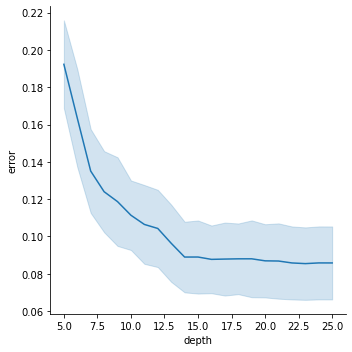

In [4]:
depths = range(5,26,1)
kf = KFold(n_splits=10,shuffle=True,random_state=0)
err = []  # for keeping results
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d,random_state=1)
    cv = cross_validate(dt,X_tr,y_tr,cv=kf,scoring="balanced_accuracy")
    err.extend(1-cv["test_score"])

result = pd.DataFrame( {"depth":np.repeat(depths,kf.n_splits),"error":err} )
sns.relplot(data=result,x="depth",y="error",kind="line",ci="sd");

Initially the error decreases, because the shallowest decision trees don't have much resolving power. Eventually, though, the testing error bottoms out. Past this point, the additional power being given to the trees is used only for overfitting.

In [5]:
result.groupby("depth").mean()

,error
depth,
5,0.192282
6,0.163447
7,0.135040
8,0.123976
9,0.118666
10,0.111359
11,0.106439
12,0.104283
13,0.096346


The table of mean CV errors suggests using a decision tree of depth 14 on the full training set. (It decreases a little bit more after that, but the variance suggests that it's not worth the additional risk of overfitting to seek such small gains.) We can now train the classifier on the entire training set—which, you'll recall, was being sliced up during cross-validation—and measure performance on the reserved testing data that has so far not been touched.

In [6]:
dt = DecisionTreeClassifier(max_depth=14,random_state=0)
dt.fit(X_tr,y_tr)
yhat = dt.predict(X_te)
print("error is",1-metrics.balanced_accuracy_score(y_te,yhat))

error is 0.08124355329007327


<!-- A variant called **stratified $k$-fold cross-validation** ensures that the folds have approximately the same percentage of examples in each target class as the original data has. -->

## Hyperparameter tuning

The validation curve is useful to find a good hyperparameter values, but only when there is a single hyperparameter to consider. When multiple options are available, it's common to perform a *grid search*, in which we try cross-validated fitting using every specified combination of parameter values. 

### Grid search 

For example, let's work with the breast cancer dataset.

In [7]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer(as_frame=True)["frame"]
y = cancer["target"]
X = cancer.drop("target",axis=1)
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=4)

We start by trying decision tree classifiers in which we vary not only the maximum depth, but some other options we did not discuss.

In [8]:
from sklearn.model_selection import GridSearchCV
grid = { "criterion":["gini","entropy"], 
         "max_depth":range(2,20,2), 
         "min_impurity_decrease":[0,0.01,0.02] }
learner = DecisionTreeClassifier(random_state=2)
kf = KFold(n_splits=5,shuffle=True,random_state=0)
grid_dt = GridSearchCV(learner,grid,scoring="f1",cv=kf)
grid_dt.fit(X_tr,y_tr)
grid_dt.best_params_,grid_dt.best_score_

({'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0.02},
 0.9631583877556006)

Next, we search over kNN classifiers. We always want use standardization as a preprocessor; note how the syntax of the grid search is adapted.

In [9]:
from sklearn.model_selection import GridSearchCV
grid = { "kneighborsclassifier__metric":["euclidean","manhattan"], 
         "kneighborsclassifier__n_neighbors":range(1,20), 
         "kneighborsclassifier__weights":["uniform","distance"] }
learner = make_pipeline(StandardScaler(),KNeighborsClassifier())
grid_knn = GridSearchCV(learner,grid,scoring="f1",cv=kf)
grid_knn.fit(X_tr,y_tr)
grid_knn.best_params_,grid_knn.best_score_

({'kneighborsclassifier__metric': 'manhattan',
  'kneighborsclassifier__n_neighbors': 3,
  'kneighborsclassifier__weights': 'uniform'},
 0.9786000507953702)

Finally, we look at SVM classifiers. Again, these should all use the `StandardScaler` preprocessor.

In [10]:
from sklearn.svm import SVC
grid = { "svc__C":[0.1,0.5,1,5,10,50,100,500,1000], "svc__kernel":["rbf","linear"] }
learner = make_pipeline(StandardScaler(),SVC())
grid_svc = GridSearchCV(learner,grid,scoring="f1",cv=kf)
grid_svc.fit(X_tr,y_tr)
grid_svc.best_params_, grid_svc.best_score_

({'svc__C': 10, 'svc__kernel': 'rbf'}, 0.9839119815391992)

We now have champions from each of the three types of classifier. The grid search fitting process also provides access to the models trained on the best hyperparameters.

In [11]:
score = lambda cl,X,y: metrics.f1_score(y,cl.predict(X))
print("best tree f1 score:",score(grid_dt,X_te,y_te))
print("best knn f1 score:",score(grid_knn,X_te,y_te))
print("best SVC f1 score:",score(grid_svc,X_te,y_te))

best tree f1 score: 0.905982905982906
best knn f1 score: 0.9672131147540983
best SVC f1 score: 0.9836065573770492


We have a winner! 

It may be instructive to rerun the competition above using different random seeds for the train--test split and the k-fold CV. The meaningfulness of the results is limited by their sensitivity to such choices.  Don't let floating-point values give you a false feeling of precision!

### Alternatives to grid search

Grid search is a brute-force approach. It is *embarrassingly parallel*, meaning that different processors can work on different locations on the grid at the same time. But it is usually too slow for large training sets, or when the search space has more than two dimensions. In such cases you can try searching over crude versions of the grid, perhaps with just part of the training data, and gradually narrow the search while using all the data. When desperate, one may try a randomized search and to guide the process with experience and intuition.

There are special techniques available when the hyperparameter has a regularization function (such as the slack-weighting $C$ parameter in the SVM), and for certain model types. You may need to take a deep dive into the sea of knowledge (and documentation) to find these.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_8f2amhv1&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_98zj3y0w" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>